In [23]:
# A fem common imports. Most imports are done prior to being used.

import os
from collections import defaultdict
from copy import deepcopy
from datetime import datetime

import matplotlib as mpl
import numpy as np
from scipy.interpolate import interp1d

from util import print_i

In [24]:
from model.bridge.bridge_705 import bridge_705_3d, bridge_705_med_config

c = bridge_705_med_config(bridge_705_3d)
# Set the directory where to save/load responses.
c.root_generated_data_dir = os.path.join("/Users/jeremy/Desktop/mesh-med-600", c.root_generated_data_dir)

INFO: Loaded vehicle data from data/a16-data/a16.csv in 0.19s
WARN: Vehicle PDF sums to 6.3, adjusted to sum to 1


In [25]:
from model.bridge import Point

point_a = Point(x=34.955, y=0, z=29.226 - 16.6)

# Annual temperature
Annual temperature, which will have to be accounted for in damage detection.

In [26]:
from classify import temperature
from model.response import ResponseType
from plot import plt
from util import resize_units

# Short aliases for response types.
rt_y = ResponseType.YTranslation
rt_s = ResponseType.Strain

# Create functions to resize, and unit strings, for each response type.
resize_y, units_y = resize_units(rt_y.units())
resize_s, _ = resize_units(rt_s.units())

temps_year = temperature.load("holly-springs")
tmin, tmax = min(temps_year["temp"]), max(temps_year["temp"])
new_tmin, new_tmax = -5, 35  # Maximum and minimum temperatures.
temps_year["temp"] = interp1d(np.linspace(tmin, tmax, 1000), np.linspace(new_tmin, new_tmax, 1000))(temps_year["temp"])
effect_year = temperature.effect(c=c, response_type=rt_y, points=[point_a], temps=temps_year["temp"])
effect_year = resize_y(effect_year)


def plot_temp_year():
    plt.scatter(temps_year["datetime"], temps_year["temp"], s=1)
    plt.ylabel("Temperature (C)")
#     ax = plt.twinx()
#     ax.scatter(temps_year["datetime"], effect_year, s=1, alpha=0)
#     plt.ylim(plt.ylim()[1], plt.ylim()[0])
#     plt.ylabel(f"{rt_y.name()} ({units_y})")
    plt.title(f"Temperature in 2019")

# plot_temp_year()

# 2 week temperature
Zooming in a little bit, to show the daily fluctuation in temperature, and how it can change over a number of days.

In [27]:
from plot.temperature import plot_day_lines

from_ = datetime.fromisoformat(f"2019-07-01T00:00")
to = datetime.fromisoformat(f"2019-07-14T23:59")
temps_month = temperature.from_to_mins(temps_year, from_, to)
effect_month = temperature.effect(c=c, response_type=rt_y, points=[point_a], temps=temps_month["temp"])
effect_month = resize_y(effect_month)


def plot_temp_two_weeks():
    plot_day_lines(temps_month["datetime"])
    plt.plot(temps_month["datetime"], temps_month["temp"])
    plt.ylabel("Temperature (C)")
    plt.legend(loc="upper right")
#     ax = plt.twinx()
#     ax.scatter(temps_month["datetime"], effect_month, s=1, alpha=0)
#     plt.ylim(plt.ylim()[1], plt.ylim()[0])
#     plt.ylabel(f"{rt_y.name()} ({units_y})")
    plt.title(f"Temperature 1 - 14 July 2019")

# plot_temp_two_weeks()

# Daily temperature
Damage detection will be done on sensor responses over a shorter period of time. The next plot shows such changes.

In [28]:
from_ = datetime.fromisoformat(f"2019-07-01T00:00")
to = datetime.fromisoformat(f"2019-07-02T23:59")
temps_days = temperature.from_to_mins(temps_year, from_, to)
effect_days = temperature.effect(c=c, response_type=rt_y, points=[point_a], temps=temps_days["temp"])
effect_days = resize_y(effect_days)


def plot_temp_days():
    plt.plot(temps_days["datetime"], temps_days["temp"])
    plot_day_lines(temps_days["datetime"])
    plt.ylabel("Temperature (C)")
    plt.legend(loc="upper right")
#     ax = plt.twinx()
#     ax.scatter(temps_days["datetime"], effect_days, s=1, alpha=0)
#     plt.ylim(plt.ylim()[1], plt.ylim()[0])
#     plt.ylabel(f"{rt_y.name()} ({units_y})")
    plt.title(f"Temperature 1 - 2 July 2019")
    
# plot_temp_days()

# Thesis temperature plot
Putting the three plots together for one concise plot for the thesis.

INFO: Saving image to /Users/jeremy/Desktop/mesh-med-600/generated-data-images/bridge-705-med-3d/healthy/temperature/temp.pdf


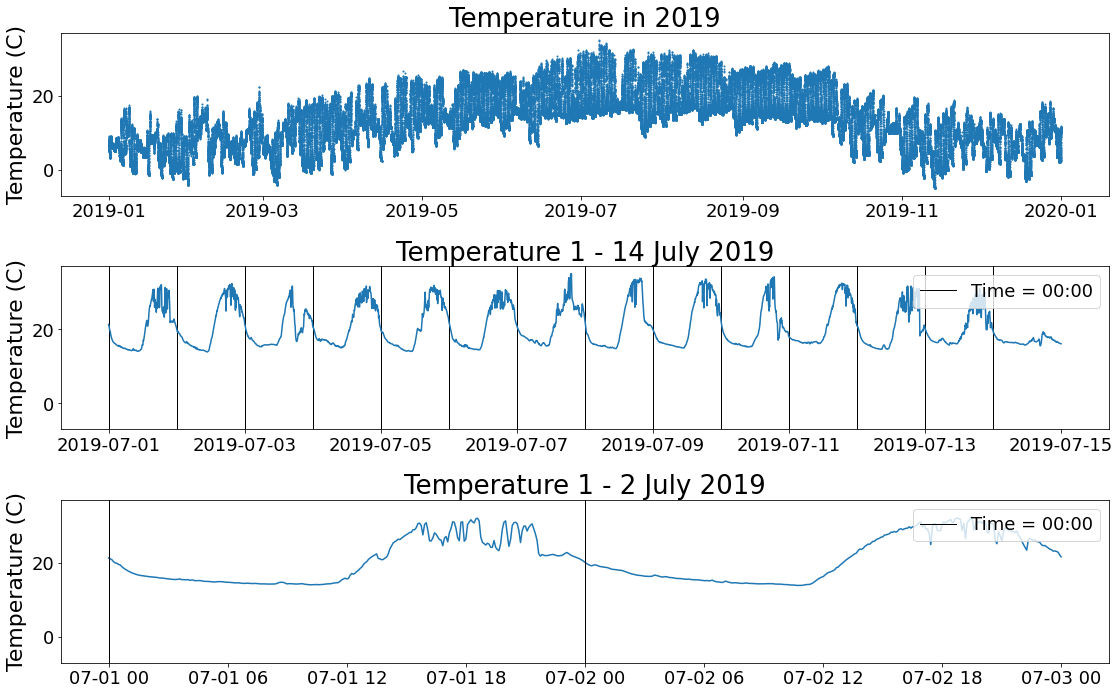

In [7]:
plt.landscape()
ax0 = plt.subplot2grid((3, 3), (1, 0), colspan=3)
plot_temp_two_weeks()
ax1 = plt.subplot2grid((3, 3), (2, 0), colspan=3)
plot_temp_days()
ax2 = plt.subplot2grid((3, 3), (0, 0), colspan=3)
plot_temp_year()

ymin, ymax = np.inf, -np.inf
for ax in [ax0, ax1, ax2]:
    if ax.get_ylim()[0] < ymin:
        ymin = ax.get_ylim()[0]
    if plt.ylim()[1] > ymax:
        ymax = ax.get_ylim()[1]
for ax in [ax0, ax1, ax2]:
    ax.set_ylim((ymin, ymax))

plt.tight_layout()
plt.savefig(c.get_image_path("temperature", "temp.pdf"))

# Traffic
48 minutes of traffic data is used for damage detection. Temperature will be sped up such that 48 hours of temperature change takes place over the 48 minutes of traffic simulation.

In [8]:
from classify.data.traffic import load_traffic
from classify.scenario.traffic import normal_traffic

total_mins = 48
total_seconds = total_mins * 60

# Create the traffic.
traffic_scenario = normal_traffic(c=c, lam=5, min_d=2)
traffic_sequence, traffic, traffic_array = load_traffic(
    c=c,
    traffic_scenario=traffic_scenario,
    max_time=total_seconds,
)
traffic_array.shape

/Users/jeremy/Desktop/mesh-med-600/generated-data/bridge-705-3d/healthy/traffic/normal-lam-5-600-2880-0,01.npy


(288001, 2400)

# Collecting responses
Responses are collected here over two damage scenarios (healthy, pier 5 settlement @ 1 mm) for the 48 minutes of traffic simulation, at a single sensor. These strains and vertical translation will allow us to see what the traffic signal looks like and how the data distributions are different under each damage scenario.

In [9]:
from fem.run.opensees import OSRunner
from classify.data.responses import responses_to_traffic_array
from classify.scenario.bridge import healthy_damage, pier_disp_damage

damage_scenarios = [healthy_damage, pier_disp_damage([(5, 1 / 1000)])]
damage_names = ["Healthy", "Pier 5 settlement by 1mm"]
response_types = [rt_y, rt_s]
sensor_point = Point(x=21, y=0, z=-8.4)  # Sensor point to investigate.

responses = [[[] for _ in response_types] for _ in damage_scenarios]
for d_i, damage_scenario in enumerate(damage_scenarios):
    for r_i, response_type in enumerate(response_types):
        responses[d_i][r_i] = responses_to_traffic_array(
            c=c,
            traffic_array=traffic_array,
            response_type=response_type,
            damage_scenario=damage_scenario,
            points=[sensor_point],
            sim_runner=OSRunner(c),
        ).T[0]  # Responses from a single point.
responses = np.array(responses)
responses.shape

(288001, 2400)
(2400, 1)
(288001, 2400)
(2400, 1)
(288001, 2400)
(2400, 1)
(288001, 2400)uilt FEMResponses in 0.01s, (ResponseType.YTranslation)
(2400, 1)


(2, 2, 288001)

# Example of traffic responses
The vertical translation and strain responses from the healthy bridge and under pier settlement, at the same point, are compared to get an idea of what the signal due to traffic looks like. At this sensor the vertical translation and strain responses are highly correlated, 0.96.

/Users/jeremy/.local/share/virtualenvs/bridge-dss-jupQo_Ui/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/jeremy/.local/share/virtualenvs/bridge-dss-jupQo_Ui/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


(-0.9621492754203181, 0.0)
(-0.9621492754203181, 0.0)


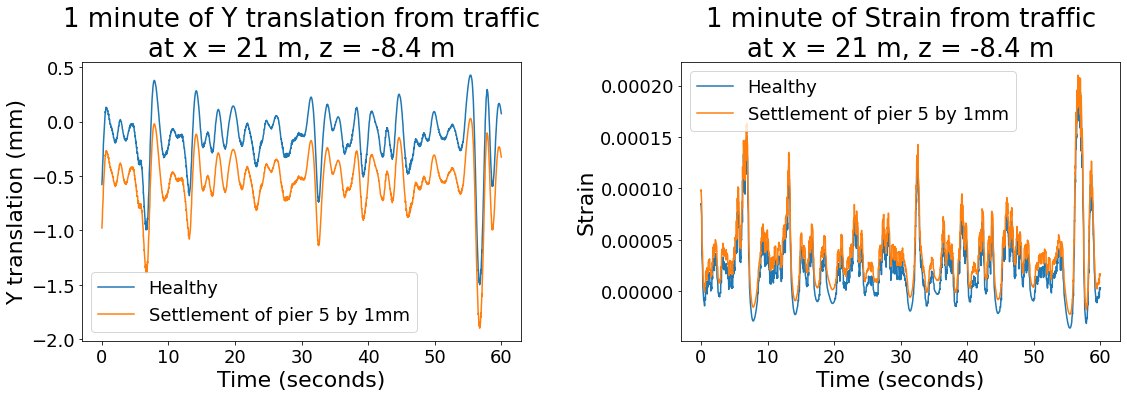

In [10]:
from scipy.stats import pearsonr

y_h_48m, s_h_48m = deepcopy(responses[0])  # Healthy bridge. Vertical translation and strain.
y_p_48m, s_p_48m = deepcopy(responses[1])  # Pier settlement. Vertical translation and strain.
# Cut to 1 minute.
y_h_1m, s_h_1m = y_h_48m[:int(len(y_h_48m) / total_mins)], s_h_48m[:int(len(s_h_48m) / total_mins)]
y_p_1m, s_p_1m = y_p_48m[:int(len(y_p_48m) / total_mins)], s_p_48m[:int(len(s_p_48m) / total_mins)]

plt.subplot(2, 2, 1) 
plt.plot(np.arange(len(y_h_1m)) * c.sensor_hz, resize_y(y_h_1m), label="Healthy")
plt.ylabel(f"{rt_y.name()} ({units_y})")
plt.xlabel(f"Time (seconds)")
plt.title(f"1 minute of {rt_y.name()} from traffic\nat x = {np.around(sensor_point.x, 2)} m, z = {np.around(sensor_point.z, 2)} m")
plt.subplot(2, 2, 2)
plt.plot(np.arange(len(s_h_1m)) * c.sensor_hz, resize_s(s_h_1m), label="Healthy")
plt.ylabel(f"{rt_s.name()}")
plt.xlabel(f"Time (seconds)")
plt.title(f"1 minute of {rt_s.name()} from traffic\nat x = {np.around(sensor_point.x, 2)} m, z = {np.around(sensor_point.z, 2)} m")
plt.subplot(2, 2, 1)
plt.plot(np.arange(len(y_p_1m)) * c.sensor_hz, resize_y(y_p_1m), label="Settlement of pier 5 by 1mm")
plt.legend()
plt.subplot(2, 2, 2)
plt.plot(np.arange(len(s_p_1m)) * c.sensor_hz, resize_s(s_p_1m), label="Settlement of pier 5 by 1mm")
plt.legend()
plt.tight_layout()

print(pearsonr(y_h_1m, s_h_1m))
print(pearsonr(y_p_1m, s_p_1m))

# Example of temperature effect
It is also useful to get an idea of what the effect of temperature is like. The responses due to temperature are clearly greater than the traffic responses.  The vertical translation and strain responses due to temperature are entirely correlated, this will possible change once the temperature model modifies the linear temperature component throughout the day, meeting this week to get an idea of approximate values.

In [11]:
########
# July #
########

temp_effect_y_48m = temperature.get_effect(
    c=c,
    response_type=rt_y,
    points=[sensor_point],
    temps=temps_month["temp"],  # All of July.
    responses=[y_h_48m],
    # Traffic data is sampled per minute. Here sped up by x60.
    # Since the given data is 48 minutes of traffic, this
    # results in 48 hours worth of temperature data taking
    # place over 48 minutes.
    speed_up=60,
)[0]  # Responses from a single point.
temp_effect_s_48m = temperature.get_effect(
    c=c,
    response_type=rt_s,
    points=[sensor_point],
    temps=temps_month["temp"],
    responses=[y_h_48m],
    speed_up=60,
)[0]  # Responses from a single point.

############
# December #
############

from_ = datetime.fromisoformat(f"2019-12-29T23:58")
to = datetime.fromisoformat(f"2019-12-31T23:59")
temps_days_2 = temperature.from_to_mins(temps_year, from_, to)

temp_effect_y_2_48m = temperature.get_effect(
    c=c,
    response_type=rt_y,
    points=[sensor_point],
    temps=temps_days_2["temp"],
    responses=[y_h_48m],
    # Traffic data is sampled per minute. Here sped up by x60.
    # Since the given data is 48 minutes of traffic, this
    # results in 48 hours of temperature data.
    speed_up=60,
)[0]  # Responses from a single point.
temp_effect_s_2_48m = temperature.get_effect(
    c=c,
    response_type=rt_s,
    points=[sensor_point],
    temps=temps_days_2["temp"],
    responses=[y_h_48m],
    speed_up=60,
)[0]  # Responses from a single point.
temp_effect_y_2_48m.shape

(288001,)

INFO: Saving image to /Users/jeremy/Desktop/mesh-med-600/generated-data-images/bridge-705-med-3d/healthy/classify/detection/temperature-difference.pdf


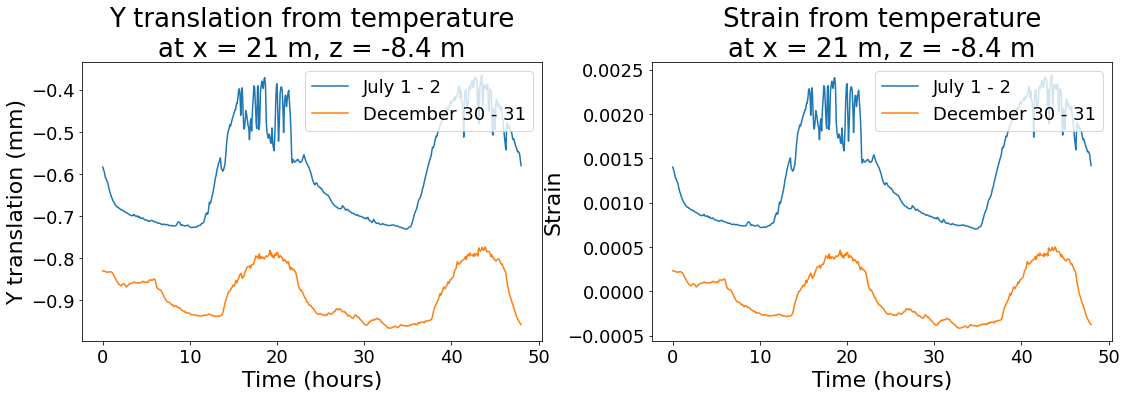

In [12]:
x = np.arange(len(responses[0][0])) * c.sensor_hz / 60

plt.subplot(2, 2, 1)
plt.plot(x, resize_y(temp_effect_y_48m), label="July 1 - 2")
plt.plot(x, resize_y(temp_effect_y_2_48m), label="December 30 - 31")
plt.ylabel(f"{rt_y.name()} ({units_y})")
plt.xlabel("Time (hours)")
plt.title(f"{rt_y.name()} from temperature\nat x = {np.around(sensor_point.x, 2)} m, z = {np.around(sensor_point.z, 2)} m")
plt.legend(loc="upper right")

plt.subplot(2, 2, 2)
plt.plot(x, resize_s(temp_effect_s_48m), label="July 1 - 2")
plt.plot(x, resize_s(temp_effect_s_2_48m), label="December 30 - 31")
plt.ylabel(f"{rt_s.name()}")
plt.xlabel("Time (hours)")
plt.title(f"{rt_s.name()} from temperature\nat x = {np.around(sensor_point.x, 2)} m, z = {np.around(sensor_point.z, 2)} m")
plt.legend(loc="upper right")
    
plt.tight_layout()
pearsonr(temp_effect_y_48m, temp_effect_s_48m)
plt.savefig(c.get_image_path("classify/detection", "temperature-difference.pdf"))

# Clustering without temperature effect
A previous image showed how the responses change between healthy and pier settlement scenarios. Here we attempt clustering of that data without any temperature noise, to show what is possible if noise were perfectly removed.

In [13]:
def equal_lims(axis, rows, cols, subplots=None):
    """Set equal x or y limits on subplots."""
    amin, amax = np.inf, -np.inf
    lim_f = plt.ylim if axis == "y" else plt.xlim
    subplots = range(1, rows * cols + 1) if subplots is None else subplots
    for p in subplots:
        plt.subplot(rows, cols, p)
        if lim_f()[0] < amin:
            amin = lim_f()[0]
        if lim_f()[1] > amax:
            amax = lim_f()[1]
    for p in subplots:
        plt.subplot(rows, cols, p)
        lim_f((amin, amax))


def filter_for_label(data, damage_scenario_label, labels):
    """Filter data for a given damage scenario label."""
    return np.array([
        data[i] for i in range(len(data))
        if labels[i] == damage_scenario_label
    ])


def colour(damage_label):
    """Deterministic mapping of integer to colour."""
    return {
        0: "tab:blue",
        1: "tab:orange",
        2: "tab:green",
        3: "tab:red",
    }[damage_label]


def plot_boundary(model):
    """Plot the decision boundary of a given model."""
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    f = np.array(list(zip(yy.ravel(), xx.ravel())))
    plt.tricontourf(f[:, 1], f[:, 0], model.predict(f), zorder=0)
    

def remove_outliers(model_f, data, other_data=None, good=1):
    """Data with outliers removed. Data must be of shape n samples x f features."""
    model = model_f().fit(data)
    pred = model.predict(data)
    if other_data is None:
        return data[pred == good]
    return data[pred == good], other_data[pred == good]


def legend_marker_size(legend, size):
    """Set the marker size for all legend markers."""
    for legend_handle in legend.legendHandles:
        legend_handle._sizes = [size]

In [14]:
# First collect and label the responses.
damage_features = []  # Dimensions: ((damage scenarios x samples per simulation) x features).
damage_labels = []  # A list of length (damage scenarios x samples per simulation), each value is the damage scenario index.
for damage_i in range(len(responses)):
    y, s = responses[damage_i]
    y, s = resize_y(y), resize_s(s)
    for response_i in range(len(y)):
        damage_features.append([y[response_i], s[response_i]])
        damage_labels.append(damage_i)
damage_features = np.array(damage_features)
damage_labels = np.array(damage_labels)

print(damage_features.shape, damage_labels.shape)
# Downsample from 100 to 1 Hz.
downsample = int(1 / c.sensor_hz)
damage_features, damage_labels = damage_features[::downsample], damage_labels[::downsample]
print(damage_features.shape, damage_labels.shape)

(576002, 2) (576002,)
(5761, 2) (5761,)


{1, -1}
INFO: k = 0: 424 / 2881 = 0.14717112113849357
INFO: k = 1: 2766 / 2880 = 0.9604166666666667
Removing outliers for damage 0
Removing outliers for damage 1
INFO: k = 0: 8 / 2428 = 0.0032948929159802307
INFO: k = 1: 2351 / 2417 = 0.9726934215970211


/Users/jeremy/.local/share/virtualenvs/bridge-dss-jupQo_Ui/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/Users/jeremy/.local/share/virtualenvs/bridge-dss-jupQo_Ui/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


INFO: Saving image to /Users/jeremy/Desktop/mesh-med-600/generated-data-images/bridge-705-med-3d/healthy/classify/detection/healthy-and-pier-comparison.pdf


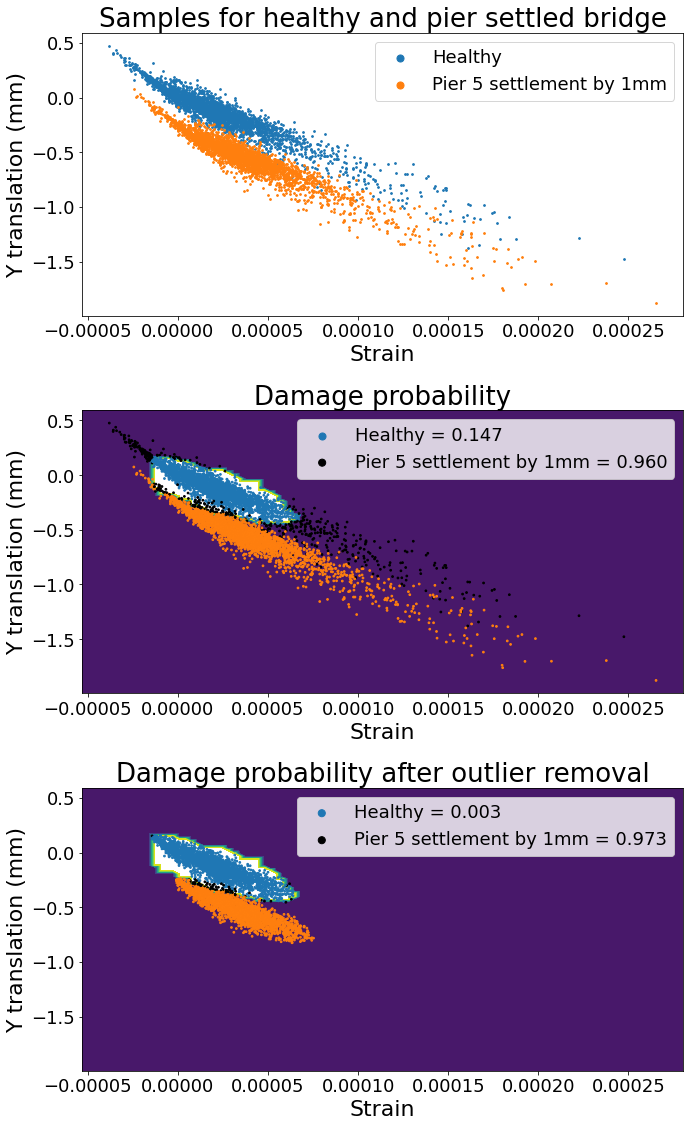

In [15]:
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

plt.portrait()  # Switch from landscape to portrait plots.

# Plot the reference data.
plt.subplot(3, 1, 1)
for damage_label in set(damage_labels):
    plot_features = filter_for_label(damage_features, damage_label, damage_labels)
    plt.scatter(plot_features[:, 1], plot_features[:, 0], label=damage_names[damage_label], s=3)
plt.ylabel(f"{rt_y.name()} ({units_y})")
plt.xlabel(f"{rt_s.name()}")
plt.title("Samples for healthy and pier settled bridge")
legend_marker_size(plt.legend(), 50)

# Choose a model.
model_f = EllipticEnvelope
model_f = IsolationForest

# Fit the model to data and predict.
model = model_f().fit(filter_for_label(damage_features, 0, damage_labels))
pred = model.predict(damage_features)
print(set(pred))

# Determine accuracy of the model.
total = defaultdict(lambda: 0)
correct = defaultdict(lambda: 0)
for i, damage_label in enumerate(damage_labels):
    total[damage_label] += 1
    if pred[i] == -1:
        correct[damage_label] += 1
        
# Print accuracy of the model.
for k, t in total.items():
    print_i(f"k = {k}: {correct[k]} / {t} = {correct[k] / t}")

# Plot the model results.
plt.subplot(3, 1, 2)
for damage_label in set(damage_labels):
    plot_features = filter_for_label(damage_features, damage_label, damage_labels)
    plot_pred = filter_for_label(pred, damage_label, damage_labels)
    cs = [colour(damage_label) if (damage_label == 0 and p == 1) or (damage_label > 0 and p == -1) else "black" for p in plot_pred]
    plt.scatter(plot_features[:, 1], plot_features[:, 0], c=cs, label=f"{damage_names[damage_label]} = {correct[damage_label] / total[damage_label]:.3f}", s=3)
plt.ylabel(f"{rt_y.name()} ({units_y})")
plt.xlabel(f"{rt_s.name()}")
plt.title("Damage probability")
legend = plt.legend()
legend_marker_size(legend, 50)
legend.legendHandles[0].set_color("tab:blue")
plot_boundary(model)

#########################
# Now without outliers! #
#########################

# Remove the outliers.
new_damage_features, new_damage_labels = [], []
for damage_label in set(damage_labels):
    print(f"Removing outliers for damage {damage_label}")
    df, dl = remove_outliers(
        model_f,
        filter_for_label(damage_features, damage_label, damage_labels),
        filter_for_label(damage_labels, damage_label, damage_labels)
    )
    new_damage_features.append(df), new_damage_labels.append(dl)
damage_features = np.concatenate(new_damage_features)
damage_labels = np.concatenate(new_damage_labels)

# Predict on the new features without outliers.
pred = model.predict(damage_features)

# Determine accuracy of the model.
total = defaultdict(lambda: 0)
correct = defaultdict(lambda: 0)
for i, damage_label in enumerate(damage_labels):
    total[damage_label] += 1
    if pred[i] == -1:
        correct[damage_label] += 1

# Print accuracy of the model.
for k, t in total.items():
    print_i(f"k = {k}: {correct[k]} / {t} = {correct[k] / t}")
    
# Plot the model results.
plt.subplot(3, 1, 3)
for damage_label in set(damage_labels):
    plot_features = filter_for_label(damage_features, damage_label, damage_labels)
    plot_pred = filter_for_label(pred, damage_label, damage_labels)
    cs = [colour(damage_label) if (damage_label == 0 and p == 1) or (damage_label > 0 and p == -1) else "black" for p in plot_pred]
    plt.scatter(plot_features[:, 1], plot_features[:, 0], c=cs, label=f"{damage_names[damage_label]} = {correct[damage_label] / total[damage_label]:.3f}", s=3)
plt.ylabel(f"{rt_y.name()} ({units_y})")
plt.xlabel(f"{rt_s.name()}")
plt.title("Damage probability after outlier removal")
legend_marker_size(plt.legend(), 50)
    
equal_lims("x", rows=3, cols=1)
equal_lims("y", rows=3, cols=1)
plot_boundary(model)
plt.tight_layout()
plt.savefig(c.get_image_path("classify/detection", "healthy-and-pier-comparison.pdf"))
plt.landscape()  # Keep as default.

# Simulation data with temperature effect
Here we combine each of the temperature effects (July and December) and each of the damage scenarios (healthy and settled pier), to get an idea of how the signal changes (both vertical translation and strain).

/Users/jeremy/.local/share/virtualenvs/bridge-dss-jupQo_Ui/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/Users/jeremy/.local/share/virtualenvs/bridge-dss-jupQo_Ui/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


INFO: Saving image to /Users/jeremy/Desktop/mesh-med-600/generated-data-images/bridge-705-med-3d/healthy/classify/detection/temp-and-damage.pdf


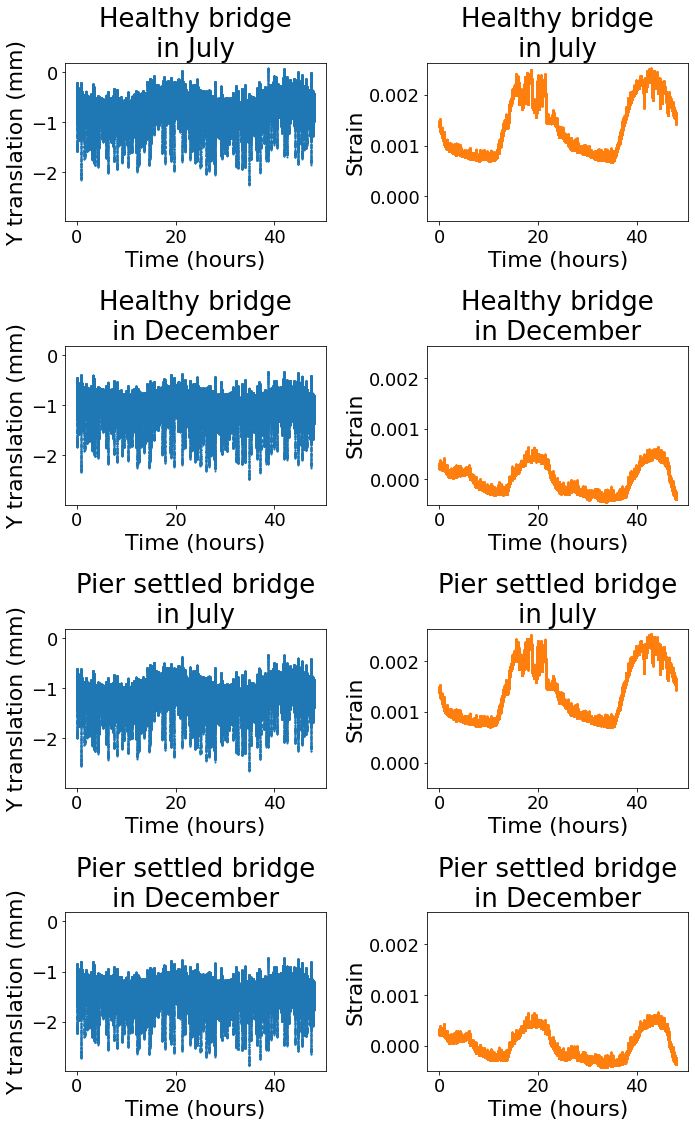

In [16]:
y_h_48m, s_h_48m = deepcopy(responses[0])  # Healthy bridge. Vertical translation and strain.
y_p_48m, s_p_48m = deepcopy(responses[1])  # Pier settlement. Vertical translation and strain.

plt.portrait()

plt.subplot(4, 2, 1)
plt.scatter(x, resize_y(y_h_48m + temp_effect_y_48m), s=1, label="total effect")
plt.ylabel(f"{rt_y.name()} ({units_y})")
plt.xlabel("Time (hours)")
plt.title("Healthy bridge\nin July")
plt.subplot(4, 2, 3)
plt.scatter(x, resize_y(y_h_48m + temp_effect_y_2_48m), s=1, label="total effect")
plt.ylabel(f"{rt_y.name()} ({units_y})")
plt.xlabel("Time (hours)")
plt.title("Healthy bridge\nin December")
plt.subplot(4, 2, 5)
plt.scatter(x, resize_y(y_p_48m + temp_effect_y_48m), s=1, label="total effect")
plt.ylabel(f"{rt_y.name()} ({units_y})")
plt.xlabel("Time (hours)")
plt.title("Pier settled bridge\nin July")
plt.subplot(4, 2, 7)
plt.scatter(x, resize_y(y_p_48m + temp_effect_y_2_48m), s=1, label="total effect")
plt.ylabel(f"{rt_y.name()} ({units_y})")
plt.xlabel("Time (hours)")
plt.title("Pier settled bridge\nin December")
equal_lims("y", 4, 2, [1, 3, 5, 7])

plt.subplot(4, 2, 2)
plt.scatter(x, resize_s(s_h_48m + temp_effect_s_48m), s=1, label="total effect", c="tab:orange")
plt.ylabel(f"{rt_s.name()}")
plt.xlabel("Time (hours)")
plt.title("Healthy bridge\nin July")
plt.subplot(4, 2, 4)
plt.scatter(x, resize_s(s_h_48m + temp_effect_s_2_48m), s=1, label="total effect", c="tab:orange")
plt.ylabel(f"{rt_s.name()}")
plt.xlabel("Time (hours)")
plt.title("Healthy bridge\nin December")
plt.subplot(4, 2, 6)
plt.scatter(x, resize_s(s_p_48m + temp_effect_s_48m), s=1, label="total effect", c="tab:orange")
plt.ylabel(f"{rt_s.name()}")
plt.xlabel("Time (hours)")
plt.title("Pier settled bridge\nin July")
plt.subplot(4, 2, 8)
plt.scatter(x, resize_s(s_p_48m + temp_effect_s_2_48m), s=1, label="total effect", c="tab:orange")
plt.ylabel(f"{rt_s.name()}")
plt.xlabel("Time (hours)")
plt.title("Pier settled bridge\nin December")
equal_lims("y", 4, 2, [2, 4, 6, 8])

plt.tight_layout()
plt.landscape()
plt.savefig(c.get_image_path("classify/detection", "temp-and-damage.pdf"))

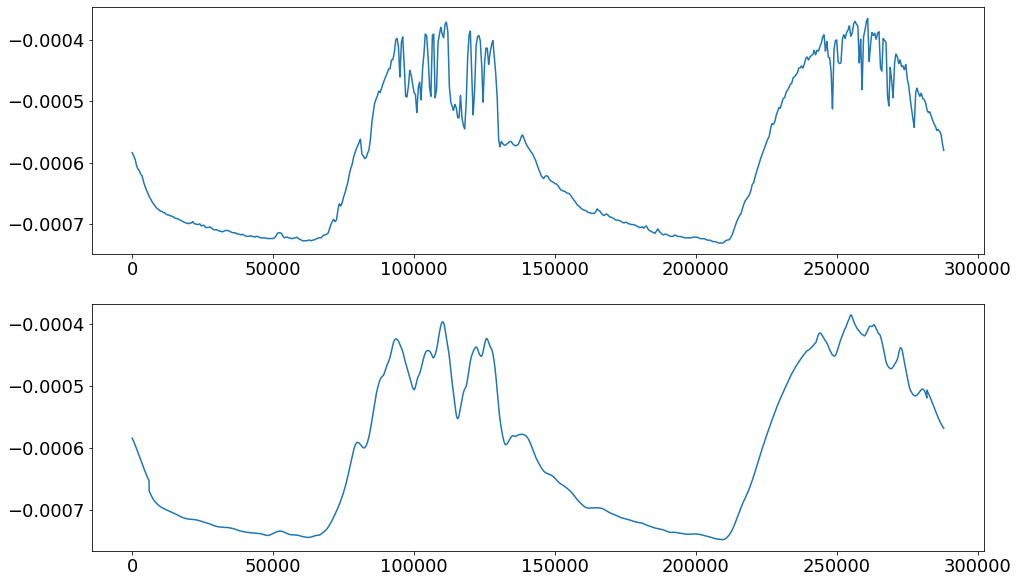

In [17]:
from scipy.signal import savgol_filter
plt.subplot(2, 1, 1)
plt.plot(temp_effect_y_48m)
temp_effect_y_48m = savgol_filter(deepcopy(temp_effect_y_48m), 12001, 4) # window size 51, polynomial order 3
temp_effect_y_2_48m = savgol_filter(deepcopy(temp_effect_y_2_48m), 12001, 4) # window size 51, polynomial order 3
temp_effect_s_48m = savgol_filter(deepcopy(temp_effect_s_48m), 12001, 4) # window size 51, polynomial order 3
temp_effect_s_2_48m = savgol_filter(deepcopy(temp_effect_s_2_48m), 12001, 4) # window size 51, polynomial order 3
plt.subplot(2, 1, 2)
plt.plot(temp_effect_y_48m)

# Clustering with temperature effect
Clustering the first minute of data from each of the four scenarios above.

In [18]:
data_and_names = [
    (y_h_48m + temp_effect_y_48m, s_h_48m + temp_effect_s_48m, "Healthy bridge in July"),
    (y_h_48m + temp_effect_y_2_48m, s_h_48m + temp_effect_s_2_48m, "Healthy bridge in December"),
    (y_p_48m + temp_effect_y_48m, s_p_48m + temp_effect_s_48m, "Pier settled bridge in July"),
    (y_p_48m + temp_effect_y_2_48m, s_p_48m + temp_effect_s_2_48m, "Pier settled bridge in December"),
]
damage_names = list(map(lambda x: x[2], data_and_names))

# First collect and label the responses.
damage_features = []  # Dimensions: ((scenarios x samples per simulation) x features).
damage_labels = []  # A list of length (scenarios x samples per simulation), each value is the damage scenario index.
for label_i, (y, s, _name) in enumerate(data_and_names):
    y, s = resize_y(deepcopy(y)), resize_s(deepcopy(s))
    for response_i in range(len(y)):
        damage_features.append([y[response_i], s[response_i]])
        damage_labels.append(label_i)
damage_features = np.array(damage_features)
damage_labels = np.array(damage_labels)

# Downsample from 100 to 1 Hz.
downsample = int(1 / c.sensor_hz)
damage_features, damage_labels = damage_features[::downsample], damage_labels[::downsample]

print(damage_features.shape)
print(damage_labels.shape)
print(set(damage_labels))

(11521, 2)
(11521,)
{0, 1, 2, 3}


{1, -1}
INFO: k = 0: 673 / 2881 = 0.23359944463727872
INFO: k = 1: 2880 / 2880 = 1.0
INFO: k = 2: 2368 / 2880 = 0.8222222222222222
INFO: k = 3: 2880 / 2880 = 1.0
Removing outliers for damage 0
Removing outliers for damage 1
Removing outliers for damage 2
Removing outliers for damage 3
INFO: k = 0: 43 / 2146 = 0.020037278657968314
INFO: k = 1: 2247 / 2247 = 1.0
INFO: k = 2: 1944 / 2249 = 0.8643841707425522
INFO: k = 3: 2196 / 2196 = 1.0


/Users/jeremy/.local/share/virtualenvs/bridge-dss-jupQo_Ui/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/Users/jeremy/.local/share/virtualenvs/bridge-dss-jupQo_Ui/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


INFO: Saving image to /Users/jeremy/Desktop/mesh-med-600/generated-data-images/bridge-705-med-3d/healthy/classify/detection/healthy-and-pier-comparison.pdf


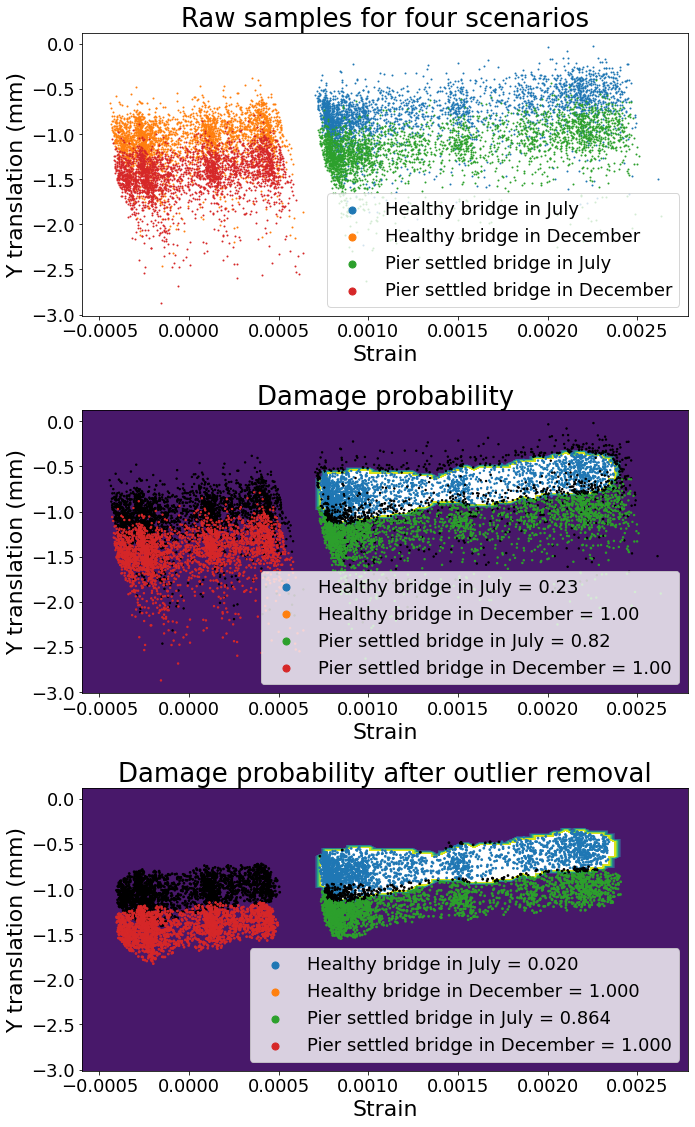

In [19]:
plt.portrait()

# Plot the reference data.
plt.subplot(3, 1, 1)
for damage_label in set(damage_labels):
    plot_features = filter_for_label(damage_features, damage_label, damage_labels)
    plt.scatter(plot_features[:, 1], plot_features[:, 0], label=damage_names[damage_label], s=1)
plt.title("Raw samples for four scenarios")
plt.ylabel(f"{rt_y.name()} ({units_y})")
plt.xlabel(f"{rt_s.name()}")
legend = plt.legend()
for damage_label in set(damage_labels):
    legend.legendHandles[damage_label].set_color(colour(damage_label))
legend_marker_size(legend, 50)

# Calculate labels with a model.
model = model_f().fit(filter_for_label(damage_features, 0, damage_labels))
pred = model.predict(damage_features)
print(set(pred))

# Determine accuracy of the model.
total = defaultdict(lambda: 0)
correct = defaultdict(lambda: 0)
healthy_labels = [0, 1]
for i, damage_label in enumerate(damage_labels):
    total[damage_label] += 1
    if pred[i] == -1:
        correct[damage_label] += 1
        
# Print accuracy of the model.
for k, t in total.items():
    print_i(f"k = {k}: {correct[k]} / {t} = {correct[k] / t}")
    
# Plot the damage detection results.
plt.subplot(3, 1, 2)
for damage_label in set(damage_labels):
    plot_features = filter_for_label(damage_features, damage_label, damage_labels)
    plot_pred = filter_for_label(pred, damage_label, damage_labels)
    cs = [colour(damage_label) if (damage_label in healthy_labels and p == 1) or (damage_label not in healthy_labels and p == -1) else "black" for p in plot_pred]
    plt.scatter(plot_features[:, 1], plot_features[:, 0], c=cs, label=f"{damage_names[damage_label]} = {correct[damage_label] / total[damage_label]:.2f}", s=2)
plt.title("Damage probability")
plt.ylabel(f"{rt_y.name()} ({units_y})")
plt.xlabel(f"{rt_s.name()}")
plt.legend()
plot_boundary(model)
legend = plt.legend()
for damage_label in set(damage_labels):
    legend.legendHandles[damage_label].set_color(colour(damage_label))
legend_marker_size(legend, 50)

#########################
# Now without outliers! #
#########################

# Remove the outliers.
new_damage_features, new_damage_labels = [], []
for damage_label in set(damage_labels):
    print(f"Removing outliers for damage {damage_label}")
    df, dl = remove_outliers(
        model_f,
        filter_for_label(damage_features, damage_label, damage_labels),
        filter_for_label(damage_labels, damage_label, damage_labels)
    )
    new_damage_features.append(df), new_damage_labels.append(dl)
damage_features = np.concatenate(new_damage_features)
damage_labels = np.concatenate(new_damage_labels)

# Predict on the new features without outliers.
pred = model.predict(damage_features)

# Determine accuracy of the model.
total = defaultdict(lambda: 0)
correct = defaultdict(lambda: 0)
for i, damage_label in enumerate(damage_labels):
    total[damage_label] += 1
    if pred[i] == -1:
        correct[damage_label] += 1

# Print accuracy of the model.
for k, t in total.items():
    print_i(f"k = {k}: {correct[k]} / {t} = {correct[k] / t}")
    
# Plot the model results.
plt.subplot(3, 1, 3)
for damage_label in set(damage_labels):
    plot_features = filter_for_label(damage_features, damage_label, damage_labels)
    plot_pred = filter_for_label(pred, damage_label, damage_labels)
    cs = [colour(damage_label) if (damage_label in healthy_labels and p == 1) or (damage_label not in healthy_labels and p == -1) else "black" for p in plot_pred]
    plt.scatter(plot_features[:, 1], plot_features[:, 0], c=cs, label=f"{damage_names[damage_label]} = {correct[damage_label] / total[damage_label]:.3f}", s=3)
plt.ylabel(f"{rt_y.name()} ({units_y})")
plt.xlabel(f"{rt_s.name()}")
plt.title("Damage probability after outlier removal")
legend = plt.legend()
for damage_label in set(damage_labels):
    legend.legendHandles[damage_label].set_color(colour(damage_label))
legend_marker_size(legend, 50)

equal_lims("x", rows=3, cols=1)
equal_lims("y", rows=3, cols=1)
plot_boundary(model)
plt.tight_layout()
plt.savefig(c.get_image_path("classify/detection", "healthy-and-pier-comparison.pdf"))

# Removal of noise.
From the previous plot, it is clear that the healthy bridge in December is misclassified as being in a damaged state, based on the model which was trained on healthy data in July. Therefore noise removal is clearly necessary, in order to show that the healthy bridge in December can be classified as healthy. We start with an experiment on the removal of daily temperature effect. Daily and annual temperature are on the same order of magnitude, therefore simply ignoring the short-term effect is not good enough, as even that will move the

In [50]:
import warnings
warnings.filterwarnings('ignore')

import numpy.polynomial.polynomial as poly


def remove_temp(num_samples, signal, p=False):
    """Data with outliers removed. Data must be of shape n samples x f features."""
    sig_ = deepcopy(signal)
    indices = list(map(int, np.linspace(0, len(signal) - 1, num_samples)))
    y_samples = []
    for i_lo, i_hi in zip(indices[:-1], indices[1:]):
        y_samples.append(np.mean(signal[i_lo:i_hi]))
#     y_samples = list(map(lambda i: signal[int(i)], indices))
#     coefs = poly.polyfit(indices, y_samples, 3)
#     fit = poly.polyval(np.arange(0, len(signal)), coefs)
    n =  np.interp(np.arange(len(signal)), indices[1:], y_samples)
    if p:
        plt.subplot(5, 1, 1)
        plt.plot(y_p_48m)
        plt.subplot(5, 1, 2)
        plt.plot(signal)
        plt.subplot(5, 1, 3)
        plt.plot(indices[1:], y_samples, marker="o")
        plt.subplot(5, 1, 4)
        plt.plot(n)
        plt.subplot(5, 1, 5)
        plt.plot(deepcopy(sig_) - n)
        equal_lims("y", 5, 1)
    return deepcopy(sig_) - n

In [ ]:
y_h_48m, s_h_48m = deepcopy(responses[0])  # Healthy bridge. Vertical translation and strain.
y_p_48m, s_p_48m = deepcopy(responses[1])  # Pier settlement. Vertical translation and strain.
len_24m = int(len(y_h_48m) / 2)
y_h_24m, s_h_24m = y_h_48m[:len_24m], s_h_48m[:len_24m]
y_p_24m, s_p_24m = y_p_48m[:len_24m], s_p_48m[:len_24m]

data_and_names = []  # List of tuple (y translation time series, strain time series, name string)

# TODO: Add other months!
for day_i in range(1, 28 + 1, 4):
    from_ = datetime.fromisoformat(f"2019-07-{('0' if day_i < 10 else '')  + str(day_i)}T00:00")
    to = datetime.fromisoformat(f"2019-07-{('0' if day_i < 9 else '') + str(day_i + 1)}T00:00")
    temps_day = temperature.from_to_mins(temps_year, from_, to)
    y_day = temperature.get_effect(c=c, response_type=rt_y, points=[point_a], temps=temps_day["temp"], responses=[y_h_24m], speed_up=60)
    s_day = temperature.get_effect(c=c, response_type=rt_s, points=[point_a], temps=temps_day["temp"], responses=[y_h_24m], speed_up=60)
    data_and_names.append((y_h_24m + y_day, s_h_24m + s_day))

In [ ]:
for day_i in day_i[:2]:
    remove_temp(24, data_and_names[day_i][0])

(288001,) (288001,)
(288001,)
(288001,) (288001,)
(288001,)
(288001,) (288001,)
(288001,)
(288001,) (288001,)
(288001,)


No handles with labels found to put in legend.


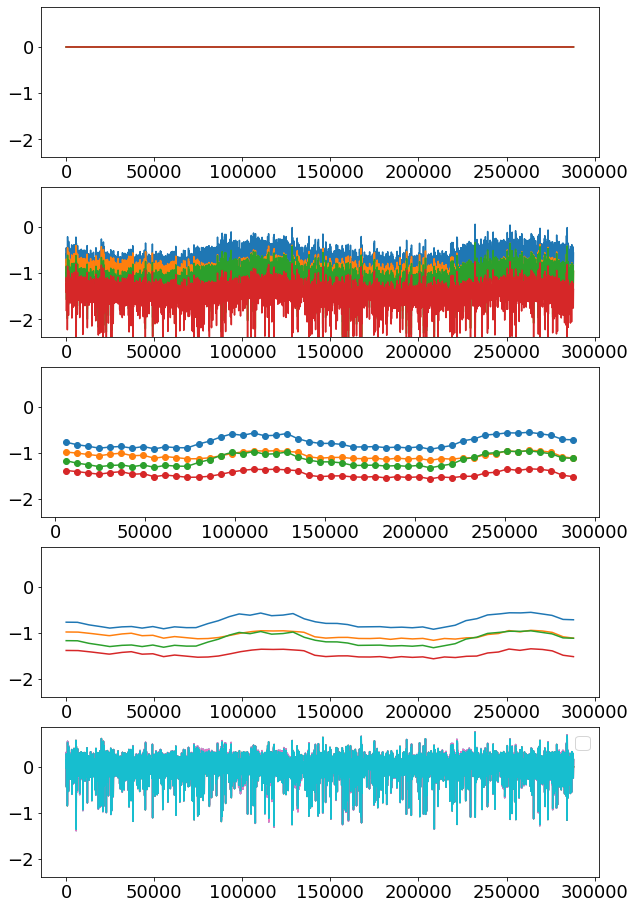

In [21]:
# First collect and label the responses.
damage_features = []  # Dimensions: ((scenarios x samples per simulation) x features).
damage_labels = []  # A list of length (scenarios x samples per simulation), each value is the damage scenario index.
for label_i, (y, s, _name) in enumerate(data_and_names):
    y, s = resize_y(deepcopy(y)), resize_s(deepcopy(s))
    plt.plot(s)
    s = remove_temp(48, s)
    plt.plot(s)
    y_new, s_new = remove_temp(48, y, p=True), remove_temp(48, s)
#     plt.subplot(len(data_and_names) * 2, 1, 1 + label_i * 2)
#     plt.plot(y)
    print(y.shape, y_new.shape)
    
#     plt.subplot(len(data_and_names), 1, 1 + label_i)
#     plt.plot(y)
#     plt.plot(y - y_new, label="new")
    print(y.shape)
#     print(r.shape)
#     plt.plot(y_r)
    for response_i in range(len(y)):
        damage_features.append([y[response_i], s[response_i]])
        damage_labels.append(label_i)
damage_features = np.array(damage_features)
damage_labels = np.array(damage_labels)
plt.legend()

# Experiment: long-term damage (pier settlement)
Here we run N simulations, combining removal techniques (daily & annual), and show how detection accuracy is changed.

(11521, 2)
(11521,)
{0, 1, 2, 3}
{1, -1}
INFO: k = 0: 576 / 2881 = 0.19993057965984035
INFO: k = 1: 708 / 2880 = 0.24583333333333332
INFO: k = 2: 1637 / 2880 = 0.5684027777777778
INFO: k = 3: 2605 / 2880 = 0.9045138888888888
Removing outliers for damage 0
Removing outliers for damage 1
Removing outliers for damage 2
Removing outliers for damage 3
INFO: k = 0: 109 / 2384 = 0.04572147651006712
INFO: k = 1: 313 / 2366 = 0.13229078613693998
INFO: k = 2: 1231 / 2357 = 0.522274077216801
INFO: k = 3: 2158 / 2336 = 0.9238013698630136
INFO: Saving image to /Users/jeremy/Desktop/mesh-med-600/generated-data-images/bridge-705-med-3d/healthy/classify/detection/healthy-and-pier-comparison.pdf


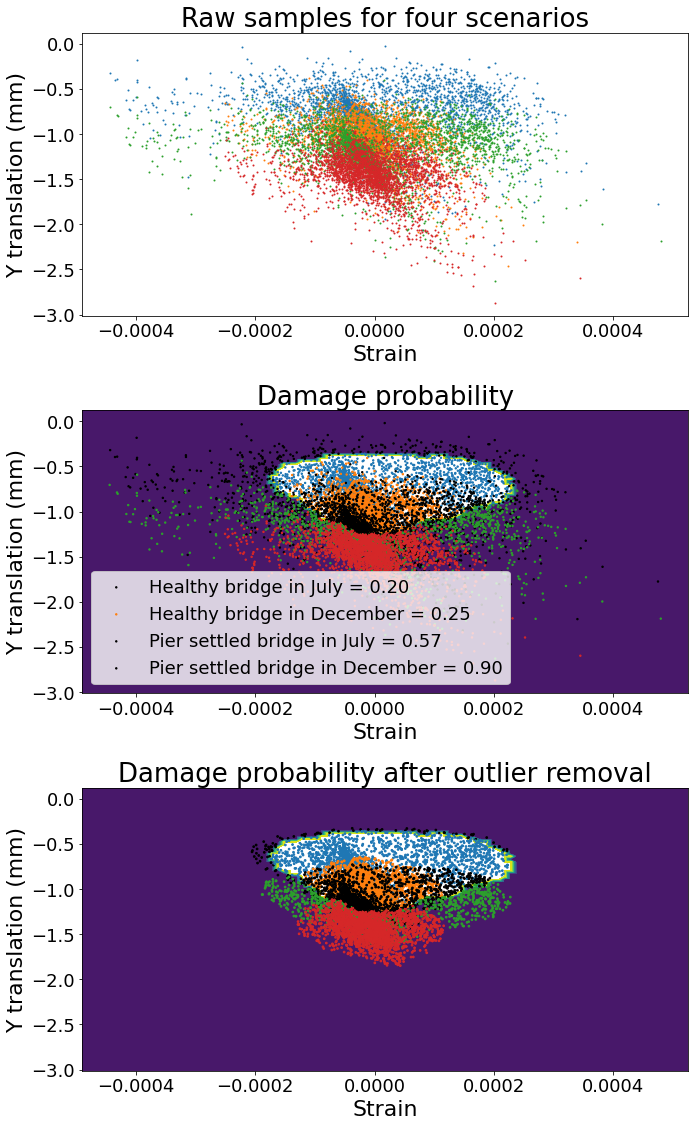

In [22]:
# Downsample from 100 to 1 Hz.
downsample = int(1 / c.sensor_hz)
damage_features, damage_labels = damage_features[::downsample], damage_labels[::downsample]

print(damage_features.shape)
print(damage_labels.shape)
print(set(damage_labels))

# Plot the reference data.
plt.subplot(3, 1, 1)
for damage_label in sorted(set(damage_labels)):
    plot_features = filter_for_label(damage_features, damage_label, damage_labels)
    plt.scatter(plot_features[:, 1], plot_features[:, 0], label=damage_names[damage_label], s=1)
plt.title("Raw samples for four scenarios")
plt.ylabel(f"{rt_y.name()} ({units_y})")
plt.xlabel(f"{rt_s.name()}")
# legend = plt.legend()
# for damage_label in set(damage_labels):
#     legend.legendHandles[damage_label].set_color(colour(damage_label))
# legend_marker_size(legend, 50)

# Calculate labels with a model.
model = model_f().fit(filter_for_label(damage_features, 0, damage_labels))
pred = model.predict(damage_features)
print(set(pred))

# Determine accuracy of the model.
total = defaultdict(lambda: 0)
correct = defaultdict(lambda: 0)
healthy_labels = [0, 1]
for i, damage_label in enumerate(damage_labels):
    total[damage_label] += 1
    if pred[i] == -1:
        correct[damage_label] += 1

# Print accuracy of the model.
for k, t in total.items():
    print_i(f"k = {k}: {correct[k]} / {t} = {correct[k] / t}")
    
# Plot the damage detection results.
plt.subplot(3, 1, 2)
for damage_label in set(damage_labels):
    plot_features = filter_for_label(damage_features, damage_label, damage_labels)
    plot_pred = filter_for_label(pred, damage_label, damage_labels)
    cs = [colour(damage_label) if (damage_label in healthy_labels and p == 1) or (damage_label not in healthy_labels and p == -1) else "black" for p in plot_pred]
    plt.scatter(plot_features[:, 1], plot_features[:, 0], c=cs, label=f"{damage_names[damage_label]} = {correct[damage_label] / total[damage_label]:.2f}", s=2)
plt.title("Damage probability")
plt.ylabel(f"{rt_y.name()} ({units_y})")
plt.xlabel(f"{rt_s.name()}")
plt.legend()
plot_boundary(model)
# legend = plt.legend()
# for damage_label in set(damage_labels):
#     legend.legendHandles[damage_label].set_color(colour(damage_label))
# legend_marker_size(legend, 50)

#########################
# Now without outliers! #
#########################

# Remove the outliers.
new_damage_features, new_damage_labels = [], []
for damage_label in set(damage_labels):
    print(f"Removing outliers for damage {damage_label}")
    df, dl = remove_outliers(
        model_f,
        filter_for_label(damage_features, damage_label, damage_labels),
        filter_for_label(damage_labels, damage_label, damage_labels)
    )
    new_damage_features.append(df), new_damage_labels.append(dl)
damage_features = np.concatenate(new_damage_features)
damage_labels = np.concatenate(new_damage_labels)

# Predict on the new features without outliers.
pred = model.predict(damage_features)

# Determine accuracy of the model.
total = defaultdict(lambda: 0)
correct = defaultdict(lambda: 0)
for i, damage_label in enumerate(damage_labels):
    total[damage_label] += 1
    if pred[i] == -1:
        correct[damage_label] += 1

# Print accuracy of the model.
for k, t in total.items():
    print_i(f"k = {k}: {correct[k]} / {t} = {correct[k] / t}")
    
# Plot the model results.
plt.subplot(3, 1, 3)
for damage_label in set(damage_labels):
    plot_features = filter_for_label(damage_features, damage_label, damage_labels)
    plot_pred = filter_for_label(pred, damage_label, damage_labels)
    cs = [colour(damage_label) if (damage_label in healthy_labels and p == 1) or (damage_label not in healthy_labels and p == -1) else "black" for p in plot_pred]
    plt.scatter(plot_features[:, 1], plot_features[:, 0], c=cs, label=f"{damage_names[damage_label]} = {correct[damage_label] / total[damage_label]:.3f}", s=3)
plt.ylabel(f"{rt_y.name()} ({units_y})")
plt.xlabel(f"{rt_s.name()}")
plt.title("Damage probability after outlier removal")
# legend = plt.legend()
# for damage_label in set(damage_labels):
#     legend.legendHandles[damage_label].set_color(colour(damage_label))
# legend_marker_size(legend, 50)

equal_lims("x", rows=3, cols=1)
equal_lims("y", rows=3, cols=1)
plot_boundary(model)
plt.tight_layout()
plt.savefig(c.get_image_path("classify/detection", "healthy-and-pier-comparison.pdf"))

plt.landscape()  # Keep as default.

# Effect of distance from pier.

The distance a sensor is from a pier will affect the accuracy of damage detection.

In [25]:
from plot.geometry import top_view_bridge
from util import flatten

pier_centers = [Point(x=pier.x, y=0, z=pier.z) for pier in c.bridge.supports]


def nearest_pier(point):
    """Index of nearest pier for a given point."""
    distance, nearest = np.inf, 0
    for pier_i, pier_point in enumerate(pier_centers):
        if point.distance(pier_point) < distance:
            distance = point.distance(pier_point)
            nearest = pier_i
    return nearest


# Number of sensors in X and Z directions.
X, Z = 200, 60
# X, Z = 100, 10
width, height = c.bridge.length / X, c.bridge.width / Z

# Sensors, as a grid.
grid_sensors = [
    [Point(x=x, y=0, z=z) for z in np.linspace(c.bridge.z_min + height / 2, c.bridge.z_max - height / 2, num=Z)]
    for x in np.linspace(c.bridge.x_min + width / 2, c.bridge.x_max - width / 2, num=X)
]
# Sensors, as a flattened list.
sensors = flatten(grid_sensors, Point)

# Selected pier, for each sensor.
sensor_piers = list(map(nearest_pier, sensors))

In [26]:
top_view_bridge(c.bridge, compass=False, piers=True)
cmap = mpl.cm.get_cmap("tab10")
for sensor, pier in zip(sensors, sensor_piers):
    plt.gca().add_patch(plt.Rectangle(
        (sensor.x - width / 2, sensor.z - height / 2),
        width,
        height,
        facecolor=cmap(pier % 10),
        edgecolor="black",
    ))
plt.title("Sensors closest to each pier")
plt.close()

In [27]:
# We downsample the traffic array before collecting responses
# because the number of points at which responses are collected
# is very lage making the calculation prohibitively expensive.

downsample = int(100 / 1)
down_traffic_array = np.array(traffic_array[::downsample])
print(traffic_array.shape)
print(down_traffic_array.shape)

responses = [[[] for _ in response_types] for _ in damage_scenarios]
for d_i, damage_scenario in enumerate(damage_scenarios):
    for r_i, response_type in enumerate(response_types):
        print(f"Collecting responses for (damage, responses) = ({damage_scenario.name}, {response_type.name()})")
        responses[d_i][r_i] = responses_to_traffic_array(
            c=c,
            traffic_array=down_traffic_array,
            response_type=response_type,
            damage_scenario=damage_scenario,
            points=sensors,
            sim_runner=OSRunner(c),
        ).T
responses = np.array(responses)
responses.shape

(288001, 2400)
(2881, 2400)
(2881, 2400)
(2400, 12000)
(2881, 2400)
(2400, 12000)
(2881, 2400)
(2400, 12000)
(2881, 2400)
(2400, 12000)


(2, 2, 12000, 2881)

In [28]:
from classify import without

# Remove unavailable sensors.
print(f"All sensors = {len(sensors)}")
without_f = without.without_sensors(c=c, pier_radius=1.5, track_radius=0.5)
classify_sensors = list(filter(lambda s: not without_f(s), sensors))
print(f"Available sensors = {len(classify_sensors)}")

# Limit to the sensors closes to pier 5.
# classify_sensors = set([sensor for sensor, pier in zip(sensors, sensor_piers) if pier == 5])

# Collect and label the responses.
damage_features = defaultdict(list)  # Dimensions: (sensors : (scenarios x samples per simulation) x features).
damage_labels = defaultdict(list)  # Dimensions: (sensors : (scenarios x samples per simulation)), each value is the damage scenario index.
for sensor_i, sensor in enumerate(sensors):
    if sensor in classify_sensors:
        print(f"Sensor {sensor_i}", end="\r")
        for damage_label, (y, s) in enumerate(responses):
            assert len(sensors) == len(y)
            y, s = resize_y(y[sensor_i]), resize_s(s[sensor_i])
            for response_i in range(len(y)):
                damage_features[sensor_i].append([y[response_i], s[response_i]])
                damage_labels[sensor_i].append(damage_label)
        damage_features[sensor_i] = np.array(damage_features[sensor_i])
        damage_labels[sensor_i] = np.array(damage_labels[sensor_i])
#         print(damage_features[sensor_i].shape)
#         print(damage_labels[sensor_i].shape)
#         print(set(damage_labels[sensor_i]))

All sensors = 12000
Available sensors = 8072


In [29]:
if True:
    acc_pier = dict()
    acc_healthy = dict()
    labels_pier = dict()
    labels_healthy = dict()
    for sensor_i, sensor in enumerate(sensors):
        if sensor in classify_sensors:
            healthy_features = filter_for_label(damage_features[sensor_i], 0, damage_labels[sensor_i])
            pier_features = filter_for_label(damage_features[sensor_i], 1, damage_labels[sensor_i])
            model = IsolationForest().fit(healthy_features)  # Train on healthy data.
            labels_healthy[sensor_i] = model.predict(healthy_features)  # Test on healthy data.
            labels_pier[sensor_i] = model.predict(pier_features)  # Test on pier settlement data.
            acc_pier[sensor_i] = len([x for x in labels_pier[sensor_i] if x == 1]) / len(labels_pier[sensor_i])
            acc_healthy[sensor_i] = len([x for x in labels_healthy[sensor_i] if x == 1]) / len(labels_healthy[sensor_i])
    #         print(f"Sensor {sensor_i}", acc_pier[sensor_i], acc_healthy[sensor_i], end="\r")
            print(f"Sensor {sensor_i}", end="\r")

In [30]:
from scipy.spatial import distance

# For each sensor, the euclidean distance between the mean of
# the features under the healthy and damaged scenarios is
# calculated.
if False:
    dist = dict()  # <sensor index: mean>
    for sensor_i, sensor in enumerate(sensors):
        if sensor in classify_sensors:
            healthy_features = filter_for_label(damage_features[sensor_i], 0, damage_labels[sensor_i])
            pier_features = filter_for_label(damage_features[sensor_i], 1, damage_labels[sensor_i])
            healthy_mean = np.mean(healthy_features.T[0]), np.mean(healthy_features.T[1])
            pier_mean = np.mean(pier_features.T[0]), np.mean(pier_features.T[1])
            dist[sensor_i] = distance.euclidean(healthy_mean, pier_mean)
            print(f"Sensor {sensor_i}", end="\r")

INFO: Saving image to /Users/jeremy/Desktop/mesh-med-600/generated-data-images/bridge-705-med-3d/healthy/classify/detection/sensors-pier-detection.pdf


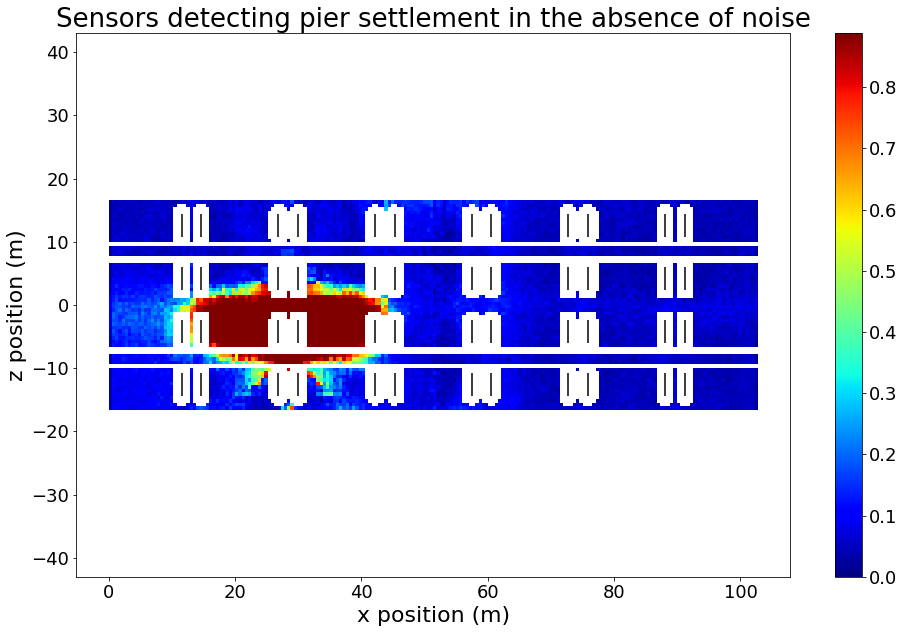

In [31]:
to_plot = acc_pier
# to_plot = dist
amin, amax = min(to_plot.values()), max(to_plot.values())
cmap = mpl.cm.get_cmap("jet")
norm = mpl.colors.Normalize(vmin=amin, vmax=amax)

for sensor_i, (sensor, pier) in enumerate(zip(sensors, sensor_piers)):
    facecolor = cmap(1 - norm(to_plot[sensor_i])) if sensor in classify_sensors else "white"
    plt.gca().add_patch(plt.Rectangle(
        (sensor.x - width / 2, sensor.z - height / 2),
        width,
        height,
        facecolor=facecolor,
#         edgecolor="black",
    ))
top_view_bridge(c.bridge, compass=False, piers=True)

plt.title("Sensors detecting pier settlement in the absence of noise")
plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm))
plt.savefig(c.get_image_path("classify/detection", "sensors-pier-detection.pdf"))

# Cracked concrete
Similar to pier settlement, we first show how the responses change under healthy and damaged scenario, except this time the damage scenario is cracked concrete rather than pier settlement.

In [ ]:
from classify.scenario.bridge import transverse_crack
    
damage_scenarios = [healthy_damage, transverse_crack()]
sensor = Point(x=52, y=0, z=-8.4)

responses = [[[] for _ in response_types] for _ in damage_scenarios]
for d_i, damage_scenario in enumerate(damage_scenarios):
    for r_i, response_type in enumerate(response_types):
        print(f"Collecting responses for (damage, responses) = ({damage_scenario.name}, {response_type.name()})")
        responses[d_i][r_i] = responses_to_traffic_array(
            c=c,
            traffic_array=down_traffic_array,
            response_type=response_type,
            damage_scenario=damage_scenario,
            points=[sensor],
            sim_runner=OSRunner(c),
        ).T
responses = np.array(responses)
responses.shape

In [ ]:
y_h, s_h = deepcopy(responses[0])  # Healthy bridge. Vertical translation and strain.
y_c, s_c = deepcopy(responses[1])  # Cracked bridge. Vertical translation and strain.
data_and_names = [
    (y_h + temp_effect_y[::downsample], s_h, "Healthy bridge in July"),
    (y_h + temp_effect_y_2[::downsample], s_h, "Healthy bridge in December"),
    (y_c + temp_effect_y[::downsample], s_c, "Cracked bridge in July"),
    (y_c + temp_effect_y_2[::downsample], s_c, "Cracked bridge in December"),
]
damage_names = list(map(lambda x: x[2], data_and_names))

# First collect and label the responses.
damage_features = []  # Dimensions: ((scenarios x samples per simulation) x features).
damage_labels = []  # A list of length (scenarios x samples per simulation), each value is the damage scenario index.
for label_i, (y, s, _name) in enumerate(data_and_names):
    y, s = resize_y(y), resize_s(s)
    for response_i in range(len(y)):
        damage_features.append([y[response_i], s[response_i]])
        damage_labels.append(label_i)
damage_features = np.array(damage_features)
damage_labels = np.array(damage_labels)

print(damage_features.shape)
print(damage_labels.shape)
print(set(damage_labels))

In [ ]:
# Plot the reference data.
for damage_label in sorted(damage_labels)[::]:
    print(f"Damage label = {damage_label}", end="\r")
    plot_features = filter_for_label(damage_features, damage_label, damage_labels)
    plt.scatter(plot_features[:, 1], plot_features[:, 0], label=damage_names[damage_label], s=1)
plt.title("Reference data")
plt.legend()
plt.show()